# Metadata

**Author**: Ejay Aguirre

**Last Updated**: 08-07-2025

**Location**: Global Station Papa, Flanking Subsurface Mooring A, Mooring Riser: CTD (90 Meters)
Class/Series CTDMOG
Make: Sea-Bird
Model: SBE 37IM

**Link**: https://dataexplorer.oceanobservatories.org/#metadata/104163/station/23/sensor/info?start=2013-07-21T22:45:00Z&end=2025-07-24T00:00:00Z&leg_clim_max=false&leg_clim_min=false&leg_minmax=false

**Reference**:
*Water Temperature*: Ocean Observatories Initiative. 2025. Sea Water Temperature, Station 104179, data from 2013-07-10 to 2025-07-10. Distributed by the Ocean Observatories Initiative Data Explorer. https://dataexplorer.oceanobservatories.org. Accessed 2025-06-09. \
*Air Temperature*: https://www.pmel.noaa.gov/ocs/data/disdel/

# Introduction
This notebook compares average air and seawater temeprature at a specific location to identify any correlations with El Niño and La Niña events, which are classsified by the NOAA ONI Index.

### Required Libraries

This notebook requires the following Python Libraries:
* `pandas`
* `numpy`
* `matplotlib`
* `xarray`
* `netCDF4`

You can install them using the following command:
```bash
!pip install pandas numpy matplotlib xarray netCDF4

In [11]:
!pip install pandas numpy matplotlib xarray netCDF4 -q

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import os

In [2]:
# See ENSO_Overlays for more information
# Be sure to change to your relative path.
NOAA_ONI_DATASHEET_PATH = "/home/jovyan/OOI_Temperature/data/noaa_oni.nc"

# The following path is from OOI's JyupterHub.
WATER_TEMP_PATH = "/home/jovyan/ooi/kdata/GP03FLMA-RIM01-02-CTDMOG043-recovered_inst-ctdmo_ghqr_instrument_recovered" 

# You can also access through OOI's THREDDS
# Link to instrument data files: https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/GP03FLMA-RIM01-02-CTDMOG043-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html
"""
Once you click the link do the following:
Be sure to click a file path that ends with .nc
Click OpenDap under the serivice.
Then, copy the Data Url link.
"""

'\nOnce you click the link do the following:\nBe sure to click a file path that ends with .nc\nClick OpenDap under the serivice.\nThen, copy the Data Url link.\n'

### Initializing, Cleaning, and Filtering Data
The following code block will:

1. Initilaizing the data path and loading the raw water temperature data from the NetCDF files using xarray.

2. Convert the xarray dataset to a *pandas* DataFrame for easier manipulation.

3. Clean the data by converting the temperature to Fahrenheit (perference) and removing outliers using the 3-sigma rule (mean +/- 3 Standard deviations.

4. Resample the data to get the desinated (i.e., daily, weekly, monthly) mean, min, max, temperatures.

*Note: When wanting to resmaple data change the variables, resample and resampleString, and run the cell again (Water Temperature). Also, be sure to change the file path for Air Temperature to fit with your resample data.*

In [3]:
"""
Resampling data
Change the value to designated parameter.
M - Monthly
W - Weekly
D - Daily
"""
resample = 'M'
resampleString = 'Monthly'

# Initailize Data Path for Water Temperature
nc_files = [os.path.join(WATER_TEMP_PATH, f) for f in os.listdir(WATER_TEMP_PATH) if f.endswith('.nc')]
ds = xr.open_mfdataset(nc_files, engine="netcdf4", combine='nested', concat_dim='obs')

# Identify Median Depth Range
depth_values = ds['depth'].values
depth_np = depth_values.compute() if hasattr(depth_values, 'compute') else depth_values

depth_median = np.nanmedian(depth_np)

# Convert to pandas dataframe
water_df = ds[['sea_water_temperature', 'depth', 'time']].to_dataframe().reset_index()

# Convert time and sort
water_df['time'] = pd.to_datetime(water_df['time'])
water_df = water_df.sort_values('time')
# print("Time range:", df['time'].min(), "to", df['time'].max()) # Ensure the timeframe is updated

# Convert Temperature to Fahrenheit
water_df["sea_water_temperature_F"] = (water_df["sea_water_temperature"] * 9/5) + 32

# Remove outliers based on Fahrenheit mean temperature
water_mean_temp_F = water_df["sea_water_temperature_F"].mean()
water_std_temp_F = water_df["sea_water_temperature_F"].std()

water_df = water_df[
    (water_df["sea_water_temperature_F"] >= water_mean_temp_F - 3 * water_std_temp_F) &
    (water_df["sea_water_temperature_F"] <= water_mean_temp_F + 3 * water_std_temp_F)
]

# Set time as index for resampling
water_df.set_index("time", inplace=True)
water_df = water_df.sort_values("time")

# Resampling Data
water_resampled = (
    water_df
    .resample(resample)["sea_water_temperature_F"]
    .mean()
    .reset_index()
    .rename(columns = {"time": "Datetime", "sea_water_temperature_F": "water_mean_F"})
)
print(water_resampled.head())

    Datetime  water_mean_F
0 2013-07-31     41.254767
1 2013-08-31     41.804916
2 2013-09-30     42.220413
3 2013-10-31     42.262000
4 2013-11-30     44.104481


/tmp/ipykernel_893/3481971466.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)["sea_water_temperature_F"]


In [5]:
# Initailize Data Path for Air Temperature
"""
Following the link provided at the top of the notebook:
Parameters will be given of what data will be needed.
In this case the following was chosen:
- Select Papa (50.1 North, 144.9 West).
- Select Time Series and Separate Plots.
- Select Air Temperature and Timeframes needed.
- Select Daily, Monthly, or 5-day (Weekly).
- Download as an ASCII Compression and click deliver.
"""
MONTHLY_AIR_TEMP_PATH = '/home/jovyan/OOI_Temperature/data/airt50n145w_mon.ascii'
WEEKLY_AIR_TEMP_PATH = '/home/jovyan/OOI_Temperature/data/airt50n145w_5day.ascii'
DAILY_AIR_TEMP_PATH = '/home/jovyan/OOI_Temperature/data/airt50n145w_dy.ascii'

# Ensure to change to designated file path
with open(MONTHLY_AIR_TEMP_PATH, 'r') as file:
    lines = file.readlines()

parsed_data = []
for line in lines[5:]: # Skips the header
    parts = line.strip().split()
    if len(parts) >= 3:
        date_str, time_str, temp_str = parts[0], parts[1], parts[2]
        try:
            datetime = pd.to_datetime(date_str + time_str, format='%Y%m%d%H%M')
            temp = float(temp_str)
            if temp != -9.99:
                parsed_data.append((datetime, temp))
        except:
            continue

# Create dataframe
air_df = pd.DataFrame(parsed_data, columns = ["Datetime", "AirTemp_C"])

# Convert to Fahrenheit
air_df["AirTemp_F"] = (air_df["AirTemp_C"] * 9/5) + 32

air_df = air_df.set_index("Datetime").sort_index()
air_df = air_df.loc["2013-07-01":]
air_df = air_df.reset_index()

# Resample Data
air_resampled = (
    air_df
    .set_index("Datetime")
    .resample(resample)["AirTemp_F"]
    .mean()
    .reset_index()
    .rename(columns = {"AirTemp_F": "air_mean_F"})
)
print(air_resampled.head())

/tmp/ipykernel_893/3532298407.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)["AirTemp_F"]


    Datetime  air_mean_F
0 2013-07-31      53.924
1 2013-08-31      57.956
2 2013-09-30      55.832
3 2013-10-31      51.152
4 2013-11-30      47.606


### Combining the Water and Air DataFrames
The following code block will concatenate both the water and air temperature into one DataFrame.

In [6]:
combined_df = pd.merge(
    air_resampled,
    water_resampled,
    on = "Datetime",
    how = 
    "inner"
).sort_values("Datetime")

print(combined_df.head())

    Datetime  air_mean_F  water_mean_F
0 2013-07-31      53.924     41.254767
1 2013-08-31      57.956     41.804916
2 2013-09-30      55.832     42.220413
3 2013-10-31      51.152     42.262000
4 2013-11-30      47.606     44.104481


### ENSO Overlay

This section loads the NOAA ONI (Oceanic Nino Index) data from an ASCII File.\
The ONI is a key indicator for El Nino and La Nina events.\
The data is processed to classify each month as 'El Nino', 'La Nina', or 'Neutral', which will be used for the background overlays in the plot(s).

In [7]:
# OVERLAY DATA (see more from ENSO_Overlays.ipynb)
ONI_PATH = '/home/jovyan/oni.ascii.txt'
oni = pd.read_csv(
    ONI_PATH,
    delim_whitespace = True,
    skiprows = 1,     
    names = ['SEAS','YEAR','TOTAL','ANOMALY']
)

# Convert the 3-letter season code into a “mid-month” integer
season_to_month = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4,
    'AMJ': 5, 'MJJ': 6, 'JJA': 7, 'JAS': 8,
    'ASO': 9, 'SON':10, 'OND':11, 'NDJ':12
}
oni['MONTH'] = oni['SEAS'].map(season_to_month)

# Build a datetime index at the 15th of the mid-month
oni['DATE'] = pd.to_datetime(dict(
    year = oni.YEAR,
    month = oni.MONTH,
    day = 15
))
oni = oni.set_index('DATE')

oni = oni.loc['2013-01-01':]

# Classify El Niño / La Niña / Neutral
def enso(x):
    if x >=  0.5: return 'El Niño'
    if x <= -0.5: return 'La Niña'
    return 'Neutral'

oni['PHASE'] = oni.ANOMALY.map(enso)

/tmp/ipykernel_893/2341182852.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oni = pd.read_csv(


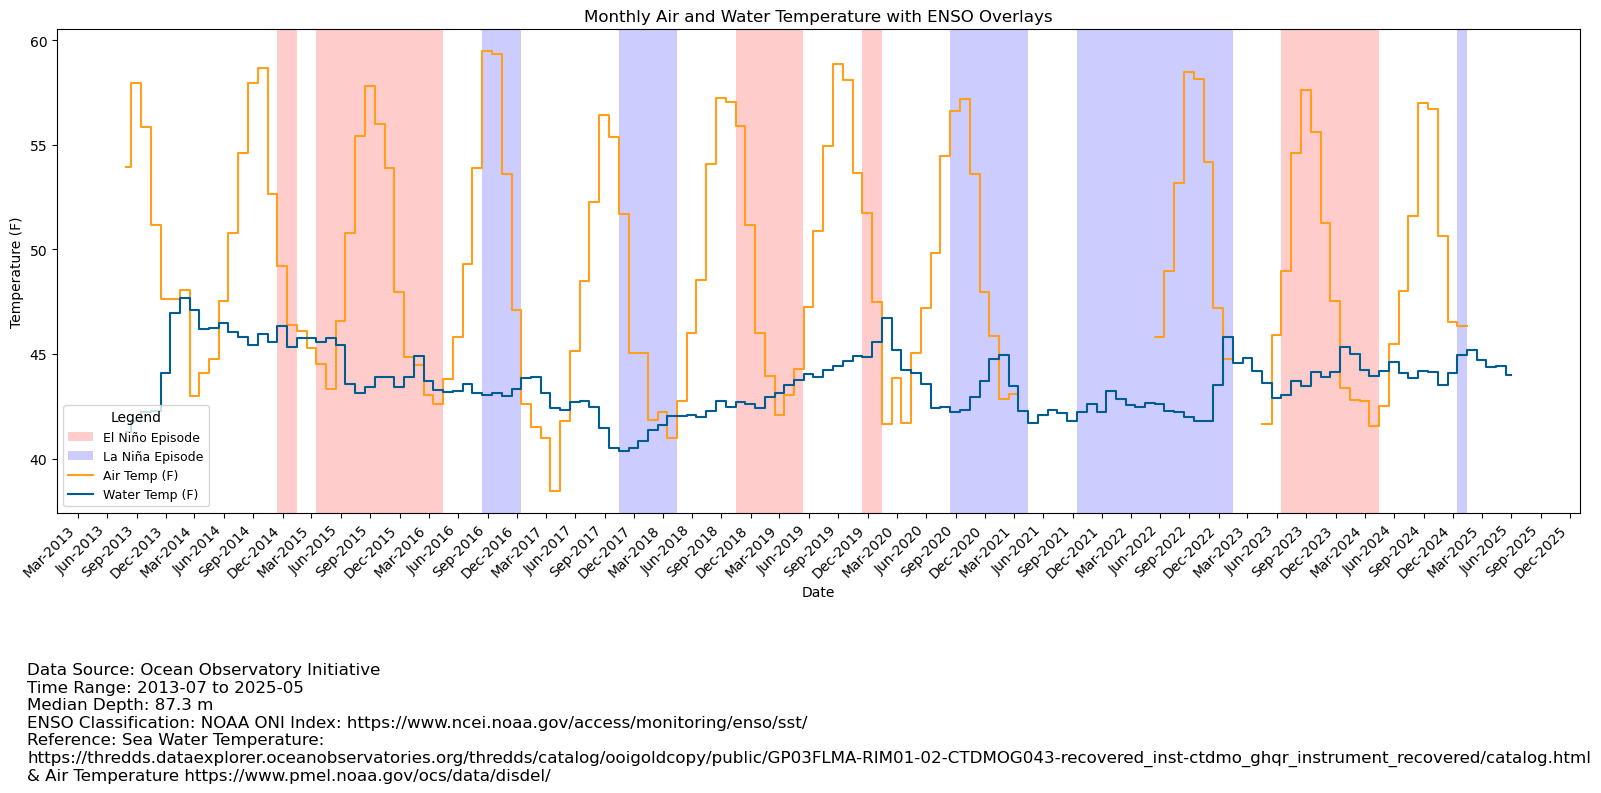

In [9]:
# Initialize Plot
fig, ax = plt.subplots(figsize = (16,6))

# ENSO Background Shading
grp = (oni.PHASE != oni.PHASE.shift()).cumsum()
for _, g in oni.groupby(grp):
    phase = g.PHASE.iloc[0]
    if phase == 'El Niño':
        ax.axvspan(g.index[0], g.index[-1], color = 'red',   alpha = 0.2, lw = 0)
    elif phase == 'La Niña':
        ax.axvspan(g.index[0], g.index[-1], color = 'blue',  alpha = 0.2, lw = 0)


# Plot Temperature Data

# Air Temperature
ax.step(
    combined_df["Datetime"],
    combined_df["air_mean_F"],
    where = "mid",
    color = "#FF9F1C",
    linewidth = 1.5,
    label = "Air Temp (F)"
)

# Water Temperature
ax.step(
    combined_df["Datetime"],
    combined_df["water_mean_F"],
    where = "mid",
    color = "#015C92",
    linewidth = 1.5,
    label = "Water Temp (F)"
)

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")

# Label Legend
enso_patches = [
    Patch(facecolor = "red", alpha = 0.2, label = "El Niño Episode"),
    Patch(facecolor = "blue", alpha = 0.2, label = "La Niña Episode")
]
handles = enso_patches + [
    mlines.Line2D([], [], color = "#FF9F1C", lw = 1.5, label = "Air Temp (F)"),
    mlines.Line2D([], [], color = "#015C92", lw = 1.5, label = "Water Temp (F)")
]
ax.legend(
    handles = handles,
    loc = "lower left",
    frameon = True,
    title = "Legend",
    fontsize = 9
)

# Metadata Footer
fig.text(
    0.02, -0.08,
    (
        "Data Source: Ocean Observatory Initiative\n"
        f"Time Range: {combined_df['Datetime'].min().strftime('%Y-%m')} to {combined_df['Datetime'].max().strftime('%Y-%m')}\n"
        f"Median Depth: {depth_median:.1f} m\n"
        "ENSO Classification: NOAA ONI Index: https://www.ncei.noaa.gov/access/monitoring/enso/sst/\n"
        "Reference: Sea Water Temperature: https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/GP03FLMA-RIM01-02-CTDMOG043-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html & Air Temperature https://www.pmel.noaa.gov/ocs/data/disdel/"
    ),
    fontsize = 12,
    ha = "left",
    va = "top",
    wrap = True
)

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.tight_layout()
# Ensure to change title(s) depending on your resampling
plt.title(f"{resampleString} Air and Water Temperature with ENSO Overlays")
plt.savefig(f"../images/{resampleString}_air_water_temp_ONI.png", dpi=300, bbox_inches="tight")
plt.show()

### Analysis

The plot reveals a subtle correlation between the ENSO events (El Niño and La Niña) and the water temperature fluctuations at the study site. While air temperature shows similar trends, the effect appears more pronounced in the sea water data. The monthly resampled sea water data provides a more clearer correlation to the ENSO overlays. Whereas weekly and daily data has bit of noise that makes it hard to see the effect of ENSO.